In [1]:
# importing all package requirements

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn import metrics

from sklearn import svm, linear_model
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import confusion_matrix

import warnings

# ignoring all warning messages
warnings.simplefilter('ignore')

### I am importing my csv's and setting them as X and y respectively

In [2]:
df = pd.read_csv('../Data/parkinsons.data')
X = pd.read_csv('../Data/X_final.csv')

In [3]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
X.head()

,MDVP:Fo(Hz),MDVP:Flo(Hz),MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ5,MDVP:APQ,HNR,spread1,spread2,PPE,pc_0,pc_1,pc_2,pc_3,pc_4
0,-0.829300,-0.952037,0.745985,0.739536,1.119147,0.332985,-0.193225,0.801323,0.480477,0.868886,0.963627,-1.774728,0.985687,-0.817591,0.230976
1,-0.770972,-0.057721,1.681731,1.768464,2.276504,1.159454,-0.634508,1.479853,1.311185,1.803605,2.340352,-1.969915,0.430976,-1.403921,0.511082
2,-0.909476,-0.109875,1.202693,1.027636,1.726176,0.699187,-0.279760,1.141445,1.017682,1.402661,2.390595,-2.283335,1.021088,-0.875077,0.240142
3,-0.909622,-0.114229,1.340396,1.207698,1.848749,0.806859,-0.281346,1.440945,1.293840,1.806954,2.289725,-2.123818,0.755570,-1.101615,0.324169
4,-0.925657,-0.130608,1.836448,1.552389,2.532491,1.216839,-0.506745,1.780940,0.096195,2.267082,3.661630,-2.394818,1.184476,-1.054083,0.507108


In [5]:
y = df.status

### Below, I create a few different functions to help with my model metrics 

In [6]:
# Function creates confusion matrix along with Accuracy, precision, sensitivity, specificity

def conf_mat(model):
    
    model_preds = model.predict(X)

    matrix = confusion_matrix(y, model_preds)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.set(font_scale=1.4)
    ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title('Confusion Matrix');

    

    TP = int(labels[1,1].split('\n')[1])
    TN = int(labels[0,0].split('\n')[1])
    FP = int(labels[0,1].split('\n')[1])
    FN = int(labels[1,0].split('\n')[1])

    Accuracy = (TN+TP)/(TN+FP+FN+TP)
    Precision = TP/(FP+TP)
    Sensitivity = TP/(TP+FN)
    Specificity = TN/(TN+FP)

    print(f'    Accuracy: {round(Accuracy,4)*100}%\n\
    Precision: {round(Precision,4)*100}%\n\
    Sensitivity: {round(Sensitivity,4)*100}%\n\
    Specificity: {round(Specificity,4)*100}%\n\
    Total samples: {TP + TN + FP + FN}')
    

In [7]:
# function for ROC/AUC curve plot

def roc_auc(model, model_name):
    y_pred_proba = model.predict_proba(X)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y, y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(15,10))
    plt.plot(fpr,tpr,label=f'AUC={round(auc,4)*100}%')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'{model_name} ROC / AUC',
                fontdict=dict(fontsize=14,
                fontweight='bold',
                color='black'),
                pad=10)
    plt.legend(loc='lower right')
    plt.show()
    ;

In [8]:
# function for cross_val_score + confidence interval

def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=620,
                         shuffle=True)
    s = cross_val_score(model, X, y.values.ravel(), cv=cv, n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, s.mean(), 2 * s.std()))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 420)

### I attempted to use a few different Naive bayes models without much luck in results.

In [10]:
gaus_nb = GaussianNB()
gaus_nb.fit(X_train, y_train)
y_pred = gaus_nb.predict(X_test)

model_score = gaus_nb.score(X_test, y_test)
model_score

0.717948717948718

In [11]:
print(score(gaus_nb, 'Gaussian Naive Bayes train:', X_train, y_train))
print(score(gaus_nb, 'Gaussian Naive Bayes test:', X_test, y_test))

Gaussian Naive Bayes train: Score: 0.74 +- 0.246
None
Gaussian Naive Bayes test: Score: 0.77 +- 0.356
None


In [12]:
nb_preds = gaus_nb.predict(X_test)
print(classification_report(y_test, nb_preds))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        10
           1       1.00      0.62      0.77        29

    accuracy                           0.72        39
   macro avg       0.74      0.81      0.71        39
weighted avg       0.87      0.72      0.73        39



### I will be trying a Random Forest while manually tweaking parameters to get my best scores.

In [13]:
rf = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 100,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.01,
#                             oob_score=True,
                            min_samples_split=.15,
#                             max_depth = 50,
                            random_state=420)

rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9423076923076923
0.8974358974358975


In [14]:
print(score(rf, 'Random Forest train:', X_train, y_train))
score(rf, 'Random Forest test:', X_test, y_test)

Random Forest train: Score: 0.86 +- 0.172
None
Random Forest test: Score: 0.82 +- 0.245


In [15]:
rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.90      0.97      0.93        29

    accuracy                           0.90        39
   macro avg       0.89      0.83      0.86        39
weighted avg       0.90      0.90      0.89        39



    Accuracy: 93.33%
    Precision: 92.41%
    Sensitivity: 99.32%
    Specificity: 75.0%
    Total samples: 195


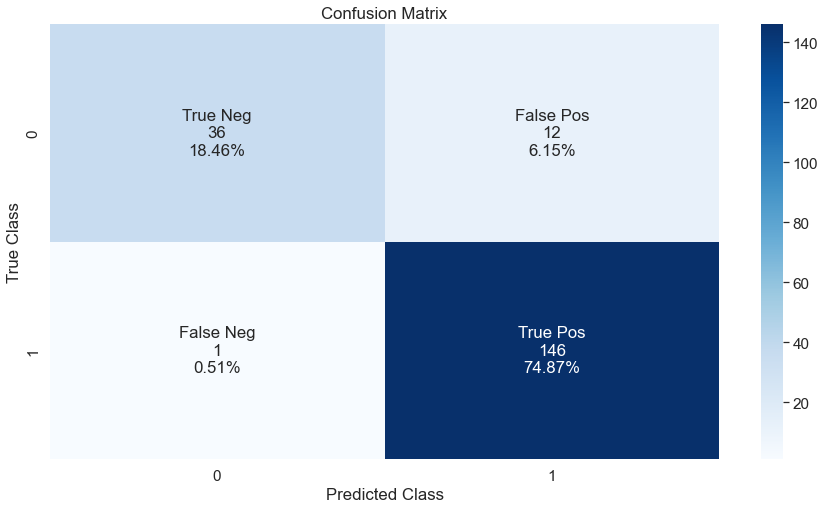

In [16]:
conf_mat(rf)

### If our goal is to only get the most accurate predictions of True Positive with the least amount of False Negatives than this random forest model would be best. Although we have a higher amount of False Positives compared to the subsequent models, it would be safer to predict a healthy person is sick (and have a follow-up second opinion) as opposed to telling a sick person they are healthy.

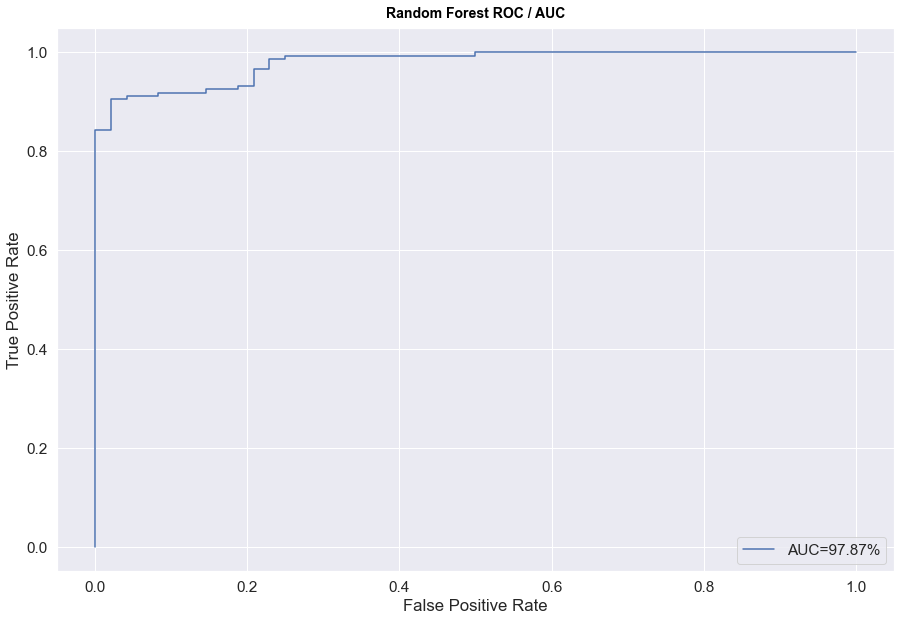

In [17]:
roc_auc(rf, 'Random Forest')

In [18]:
feat_imps = pd.DataFrame({'Feature':X.columns,
                                  'Importance %':rf.feature_importances_*100}).sort_values('Importance %', ascending=False)
feat_imps.reset_index(inplace=True, drop=True)
feat_imps

,Feature,Importance %
0,PPE,16.214982
1,spread1,15.669335
2,MDVP:Fo(Hz),14.866709
3,spread2,9.889945
4,MDVP:Flo(Hz),6.460749
5,MDVP:APQ,5.576448
6,pc_0,5.453826
7,Shimmer:APQ5,5.077828
8,MDVP:Shimmer,4.568459
9,MDVP:Shimmer(dB),3.906924


### For the random forest model I have extracted the feature importances

''

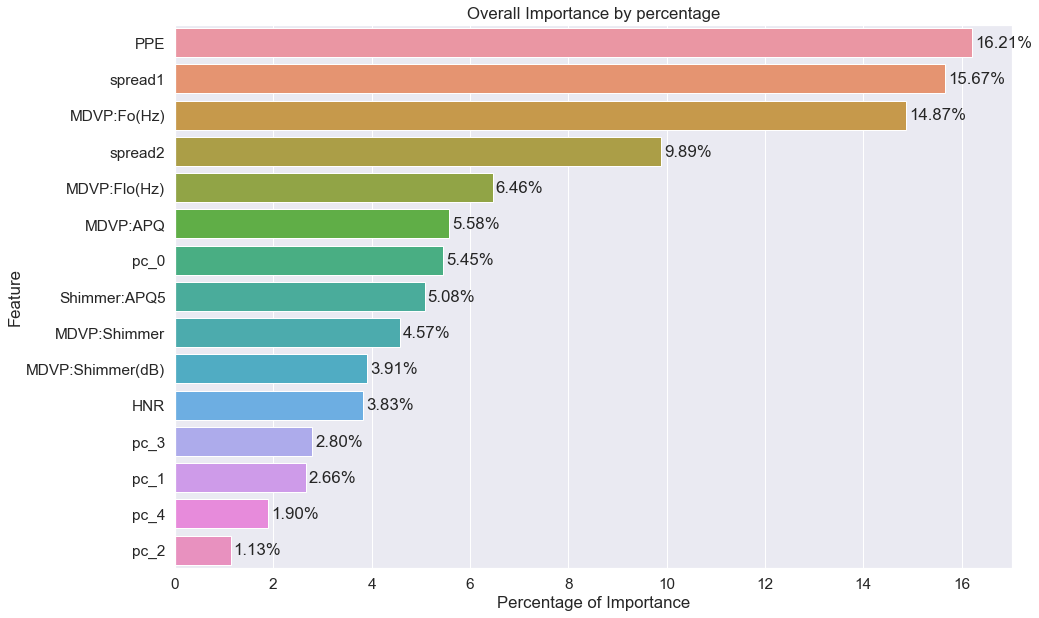

In [19]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Importance %', y='Feature', data=feat_imps)
ax.set_xlabel('Percentage of Importance')
ax.set_title('Overall Importance by percentage')

# bar_labs = [100*a for a in feat_imps]
annotations = ax.bar_label(ax.containers[0], fmt='%.2f%%', padding=3)
# annotations = ax.bar_label(ax.containers[0], fmt=bar_labs, padding=3)
# ax.margins(x=0.1)
# for i in ax.containers:
#     ax.bar_label(i)  
;

### Below I conduct a grid search for SVM model parameters

In [20]:
svm_model = svm.SVC(random_state=420)

gamma_range = np.logspace(-2, 3, 15) 
C_range = np.logspace(-2, 3, 15)
kernel_range = ['linear',
                'poly',
                'rbf',
                'sigmoid']

param_grid = dict(gamma=gamma_range,
                  C=C_range,
                  kernel=kernel_range)

grid = GridSearchCV(svm_model, param_grid, cv = 5,
                    scoring = 'accuracy', verbose = 1, n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5, estimator=SVC(random_state=420), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [21]:
print(grid.best_params_)
print(grid.score(X_train, y_train))
print(grid.score(X_test, y_test))
print(f'Grid best score {grid.best_score_}')

{'C': 16.378937069540648, 'gamma': 0.11787686347935872, 'kernel': 'rbf'}
1.0
0.8974358974358975
Grid best score 0.9612903225806452


In [22]:
score(grid, 'SVM Grid search, train:', X_train, y_train)
print(score(grid, 'SVM Grid search, test:', X_test, y_test))

SVM Grid search, train: Score: 0.92 +- 0.140
SVM Grid search, test: Score: 0.77 +- 0.356
None


In [23]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.96      0.90      0.93        29

    accuracy                           0.90        39
   macro avg       0.86      0.90      0.87        39
weighted avg       0.91      0.90      0.90        39



    Accuracy: 97.95%
    Precision: 99.31%
    Sensitivity: 97.96000000000001%
    Specificity: 97.92%
    Total samples: 195


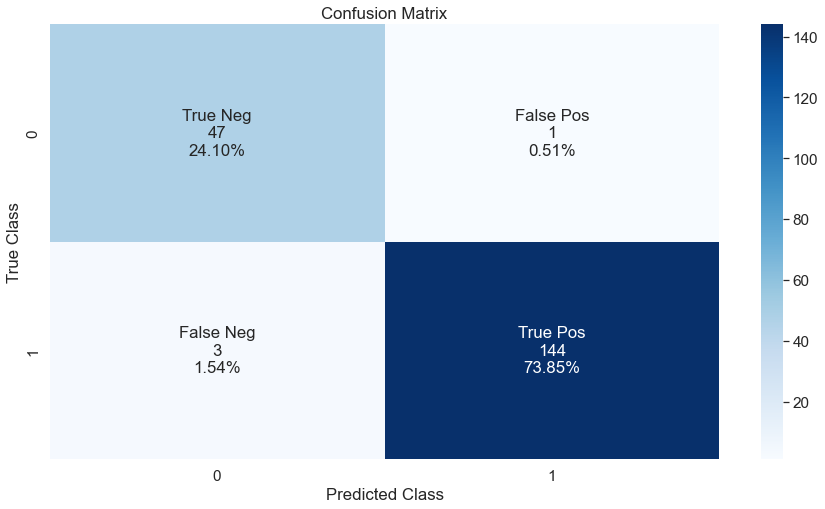

In [24]:
conf_mat(grid)

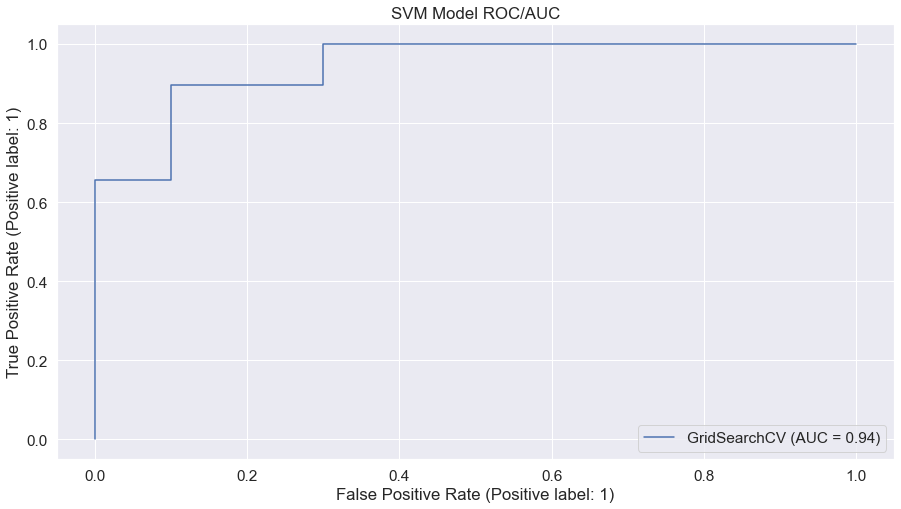

In [25]:
metrics.plot_roc_curve(grid, X_test, y_test) 
plt.title('SVM Model ROC/AUC')
plt.show()

### The SVM model performed better at predicting both classes overall with predicting all but 1 False Positive correctly. Despite this fact, it has a few additional False Negatives compared to the random forest. 

In [26]:
counter = Counter(y_train)
print('Before', counter)

# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After', counter)

Before Counter({1: 118, 0: 38})
After Counter({1: 118, 0: 118})


In [27]:
svm2_model = svm.SVC(random_state=420)

gamma_range = np.logspace(-2, 3, 15) 
C_range = np.logspace(-2, 3, 15)
kernel_range = ['linear',
                'poly',
                'rbf',
                'sigmoid']

param_grid = dict(gamma=gamma_range,
                  C=C_range,
                  kernel=kernel_range)

grid2 = GridSearchCV(svm2_model, param_grid, cv = 5,
                    scoring = 'accuracy', verbose = 1, n_jobs = -1)

grid2.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5, estimator=SVC(random_state=420), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'gamma': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [28]:
print(grid2.best_params_)
print(grid2.score(X_train, y_train))
print(grid2.score(X_test, y_test))
print(f'Grid best score {grid2.best_score_}')

{'C': 0.6105402296585329, 'gamma': 0.6105402296585329, 'kernel': 'rbf'}
1.0
0.8461538461538461
Grid best score 0.9915780141843971


In [29]:
grid2_predictions = grid2.predict(X_test)
print(classification_report(y_test, grid2_predictions))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.90      0.90      0.90        29

    accuracy                           0.85        39
   macro avg       0.80      0.80      0.80        39
weighted avg       0.85      0.85      0.85        39



### I attempted to use SMOTE to oversample the minority class for better class prediction. It did not help our model.

    Accuracy: 96.92%
    Precision: 97.96000000000001%
    Sensitivity: 97.96000000000001%
    Specificity: 93.75%
    Total samples: 195


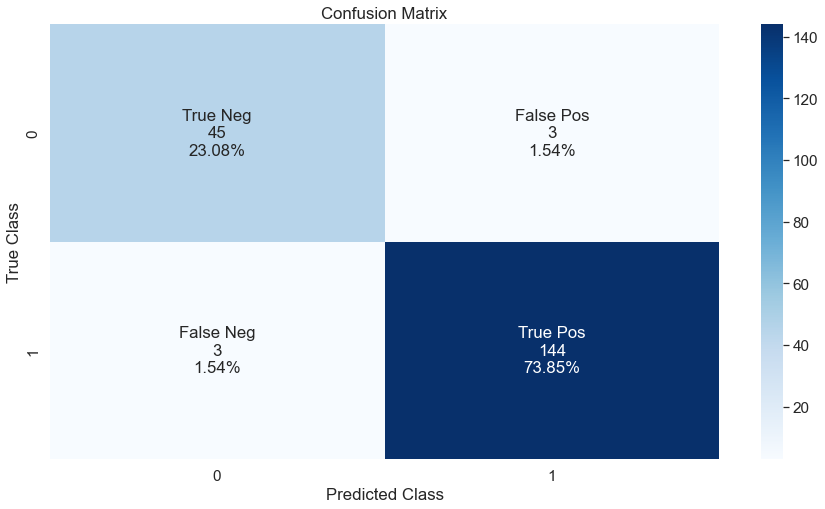

In [30]:
conf_mat(grid2)

In [31]:
gboosting = GradientBoostingClassifier(random_state=420)

param = {
#     'loss':['deviance'],
    'learning_rate': [0.75,0.8,0.9,0.95,1, 1.05, 1.1,1.15,1.2,1.3,1.4,
                      1.5,1.6,1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5],
    'min_samples_split': [0.05,0.1,0.15,0.2],
#     'min_samples_leaf': np.logspace(0.1, 0.5, 12),
    'max_depth':[2,3,4,5],
#     'max_features':['log2','sqrt'],
#     'criterion': ['friedman_mse',  'squared_error'],
#     'subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    'n_estimators':[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
    }

#passing the scoring function in the GridSearchCV
gboost2 = GridSearchCV(gboosting, param, scoring='accuracy',
                      refit=True,cv=2, n_jobs=-1)
gboost2.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=GradientBoostingClassifier(random_state=420),
             n_jobs=-1,
             param_grid={'learning_rate': [0.75, 0.8, 0.9, 0.95, 1, 1.05, 1.1,
                                           1.15, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
                                           1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4,
                                           2.5],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_split': [0.05, 0.1, 0.15, 0.2],
                         'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50,
                                          55, 60, 65, 70, 75, 80]},
             scoring='accuracy')

In [32]:
print(gboost2.best_params_)
print(gboost2.score(X_train, y_train))
print(gboost2.score(X_test, y_test))
print(f'Grid best score {gboost2.best_score_}')

{'learning_rate': 0.8, 'max_depth': 4, 'min_samples_split': 0.15, 'n_estimators': 15}
1.0
0.9230769230769231
Grid best score 0.9294871794871795


    Accuracy: 98.46000000000001%
    Precision: 99.32%
    Sensitivity: 98.64%
    Specificity: 97.92%
    Total samples: 195


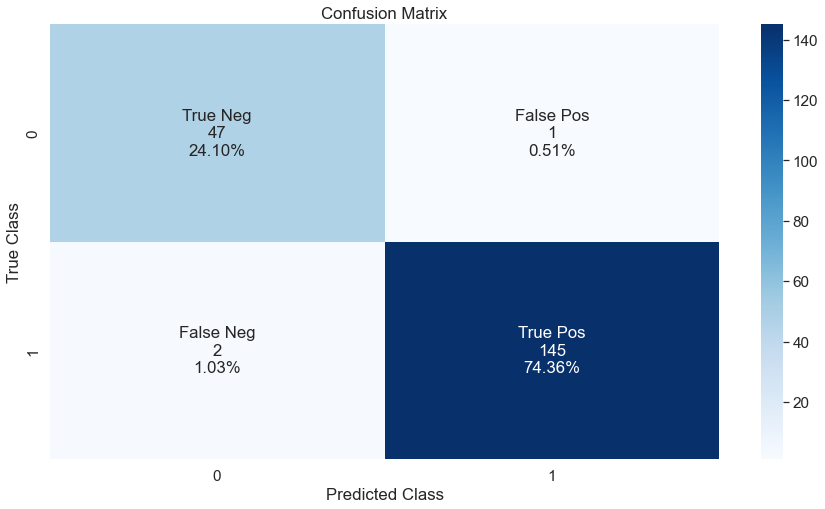

In [33]:
conf_mat(gboost2)

### The last model that I attempted to use was the Gradient Boosting model. It performed Best overall out of all of our models that we tried

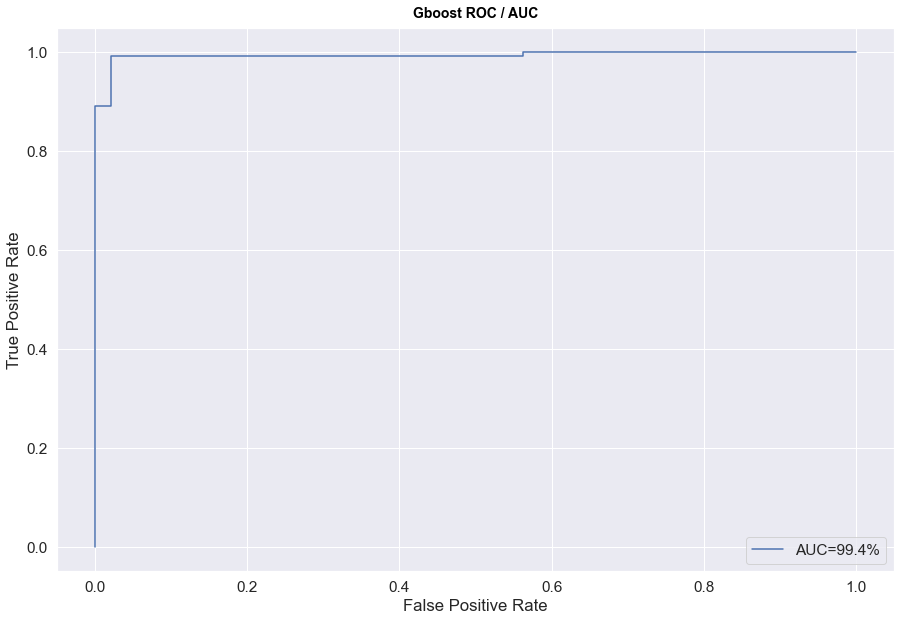

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Fitting 5 folds for each of 900 candidat

In [34]:
roc_auc(gboost2, 'Gboost')

---------------------
---------------------
---------------------

## Conclusions and Recommendations:
-  Given the success of our models, it would seem parkinson's disease can be successfully predicted using recordings of a patient's voice. I feel this would be an excellent tool for a doctor to use while in early stages of diagnosing if a patient may have Parkinson's disease. I believe that with some further work I would be able to build an algorithm that could take in raw vocal data and feed it through a pipeline where everything gets processed and sent through to the final production model. 


- As far as which model I would choose for production. I think the first model I would choose for production would be my Random Forest model. It performed the best at accurately predicting sick patients with only 1 false negative. It did falsely predict that 12 patients were sick when in fact they were healthy, but we could use this as a screener to get the patient examined again by other means. It is safer to tell a healthy patient that they may have the disease as opposed to telling a sick patient that they are completely healthy.


- With that note I would only use the random forest model until I can improve the gradient boosting model to the level of accuracy at predicting sick patients to that of the random forest one. The reason is that the gradient boosting performed better overall. It only had 2 false negatives and 1 false positive. 


- I recommend investing time and money in my work in order to complete these goals so we could have a non-invasive tool that could quickly and accurately determine if a patient may or may not have Parkinson's disease. This could be used in a doctor's office or hospital setting where they could ask a the patient to say a predetermined phrase in a microphone and get a result in minutes. 